In [1]:
import data, model.unet, model.autoencoder, loss, function
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import torch.utils.tensorboard as tb
import torchvision

%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

In [2]:
DEBUG_DATASET = True

In [3]:
tb_writer = tb.SummaryWriter('log')

In [4]:
VAL_PORTION = 0.1
ITERATIONS = 15002
VAL_ITERATIONS = 5
RESOLUTION = 32
CHANNELS = 3
STYLE_DIM = 256
BATCH_SIZE = 8
LOSS_TYPE = 'l1'

CONTENT_LOSS_WEIGHTS = {
    #'relu_1_1' : 1e-2,
    #'relu_4_2' : 5e-3,
    'relu_4_2' : 5e-1,
}

STYLE_LOSS_WEIGHTS = {
    'relu_1_1' : 1e2,
    'relu_2_1' : 1e2,
    'relu_3_1' : 1e2,
    'relu_4_1' : 1e2,
    'relu_5_1' : 1e2,
}
DISENTANGLEMENT_LOSS_WEIGHT = 1e-20
KLD_LOSS_WEIGHT = 1e-20#1.0

In [5]:
if DEBUG_DATASET:
    data_style = data.load_debug_dataset('../dataset/debug/style', resolution=RESOLUTION)
    data_content = data.load_debug_dataset('../dataset/debug/content', resolution=RESOLUTION)
else:    
    data_style = data.load_dataset('../dataset/style', resolution=RESOLUTION)
    data_content = data.load_dataset('../dataset/content', resolution=RESOLUTION)

In [6]:
data_content_train, data_content_val = torch.utils.data.random_split(data_content, [len(data_content) - int(VAL_PORTION * len(data_content)), int(VAL_PORTION * len(data_content))])
data_style_train, data_style_val = torch.utils.data.random_split(data_style, [len(data_style) - int(VAL_PORTION * len(data_style)), int(VAL_PORTION * len(data_style))])
data_loader_content_train = DataLoader(data_content_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_content_val = DataLoader(data_content_val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_style_train = DataLoader(data_style_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_style_val = DataLoader(data_style_val, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
data_loader_train = data.DatasetTripletIterator(data_loader_content_train, data_loader_style_train)
data_loader_val = data.DatasetTripletIterator(data_loader_content_val, data_loader_style_val)

In [7]:
CONTENT_DOWN_CONVOLUTIONS = 3
STYLE_DOWN_CONVOLUTIONS = 4

normalization = ['adain', 'adain', None, None, None]
unet = model.unet.UNetAutoencoder(3, STYLE_DIM, residual_downsampling=False, residual_adain=False, residual_upsampling=True, 
        down_normalization='in', up_normalization='adain', num_adain_convolutions=3, 
        num_downup_convolutions=CONTENT_DOWN_CONVOLUTIONS, output_activation='sigmoid')
style_encoder = model.autoencoder.Encoder(2 * STYLE_DIM, num_down_convolutions=CONTENT_DOWN_CONVOLUTIONS)


loss_net = loss.LossNet()
_ = loss_net.eval()

In [8]:
if torch.cuda.is_available(): 
    unet = unet.cuda()
    style_encoder = style_encoder.cuda()
    loss_net = loss_net.cuda()

trainable_parameters = []
for parameter in unet.parameters():
    trainable_parameters.append(parameter)
for parameter in style_encoder.parameters():
    trainable_parameters.append(parameter)

In [9]:
optimizer = torch.optim.Adam(trainable_parameters, lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

In [10]:
def forward(content_image_1, content_image_2, style_image):
    style_parameters = style_encoder(style_image)
    style_mean, style_logvar = style_parameters[..., : STYLE_DIM], style_parameters[..., STYLE_DIM : ]
    style_encoding = function.sample_normal(style_mean, style_logvar)
    stylized_1 = unet(content_image_1, style_encoding)
    stylized_2 = unet(content_image_2, style_encoding)
    return stylized_1, stylized_2, style_encoding, style_mean, style_logvar

In [11]:
def losses(content_image_1, style_image, stylized_1, stylized_2, style_encoding, style_mean, style_logvar):
    features_content_1 = loss_net(content_image_1)
    features_style = loss_net(style_image)
    features_stylized_1 = loss_net(stylized_1)
    
    perceptual_loss = loss.perceptual_loss(features_content_1, features_stylized_1, CONTENT_LOSS_WEIGHTS, loss=LOSS_TYPE)
    style_loss = loss.style_loss(features_style, features_stylized_1, STYLE_LOSS_WEIGHTS, loss=LOSS_TYPE)
    
    # Sample style encodings for the stylizations
    stylized_1_style_stats = style_encoder(stylized_1)
    stylized_1_style = function.sample_normal(stylized_1_style_stats[..., : STYLE_DIM], stylized_1_style_stats[..., STYLE_DIM : ])
    stylized_2_style_stats = style_encoder(stylized_2)
    stylized_2_style = function.sample_normal(stylized_2_style_stats[..., : STYLE_DIM], stylized_2_style_stats[..., STYLE_DIM : ])
    
    
    disentanglement_loss = loss.disentanglement_loss(style_encoding, stylized_1_style, stylized_2_style)
    kld_loss = loss.kld_loss(style_mean, style_logvar)
    
    return perceptual_loss + style_loss + disentanglement_loss * DISENTANGLEMENT_LOSS_WEIGHT + kld_loss * KLD_LOSS_WEIGHT, \
        perceptual_loss, style_loss, disentanglement_loss, kld_loss
    

    0 / 15002: loss : 6.7580 -- perceptual loss : 1.3169 -- style loss : 5.4411 -- disentanglement loss : 0.0000 -- kld loss : 2093.7976
Validation...


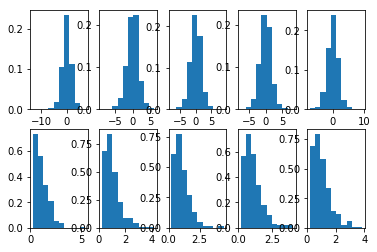


Average val loss: 0.0
Training with lr 1e-05...
  100 / 15002: loss : 5.9538 -- perceptual loss : 1.4389 -- style loss : 4.5150 -- disentanglement loss : 0.0510 -- kld loss : 1925.6201
Validation...


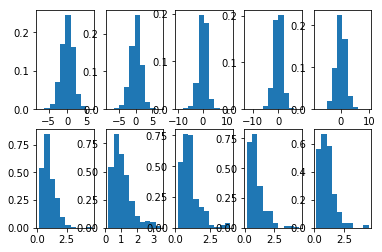


Average val loss: 0.0
Training with lr 1e-05...
  200 / 15002: loss : 5.6997 -- perceptual loss : 1.3307 -- style loss : 4.3690 -- disentanglement loss : 0.0000 -- kld loss : 2004.3765
Validation...


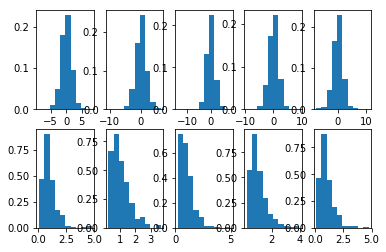


Average val loss: 0.0
Training with lr 1e-05...
  300 / 15002: loss : 7.1570 -- perceptual loss : 1.3289 -- style loss : 5.8280 -- disentanglement loss : 0.2144 -- kld loss : 2019.2224
Validation...


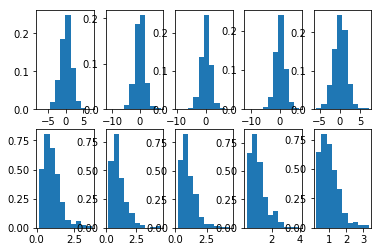


Average val loss: 0.0
Training with lr 1e-05...
  400 / 15002: loss : 6.6983 -- perceptual loss : 1.3101 -- style loss : 5.3882 -- disentanglement loss : 0.0000 -- kld loss : 2040.2679
Validation...


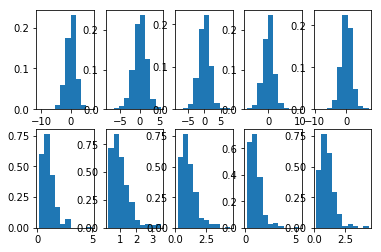


Average val loss: 0.0
Training with lr 1e-05...
  500 / 15002: loss : 6.7682 -- perceptual loss : 1.2370 -- style loss : 5.5313 -- disentanglement loss : 0.0000 -- kld loss : 2059.6746
Validation...


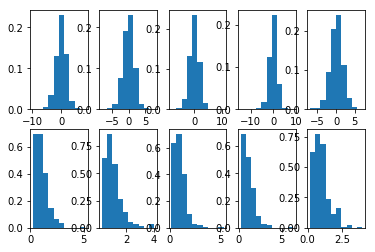


Average val loss: 0.0
Training with lr 1e-05...
  600 / 15002: loss : 4.9382 -- perceptual loss : 1.1134 -- style loss : 3.8248 -- disentanglement loss : 0.0113 -- kld loss : 2117.2627
Validation...


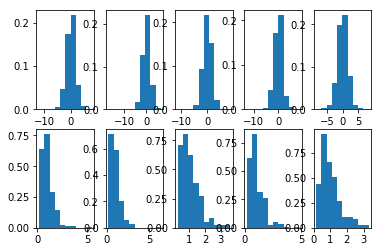


Average val loss: 0.0
Epoch     6: reducing learning rate of group 0 to 1.0000e-06.
Training with lr 1.0000000000000002e-06...
  700 / 15002: loss : 5.1886 -- perceptual loss : 1.3021 -- style loss : 3.8865 -- disentanglement loss : 0.0000 -- kld loss : 2093.9866
Validation...


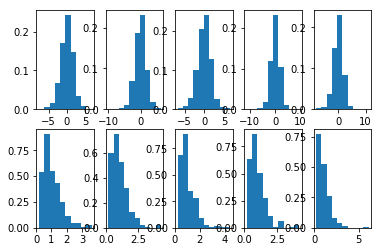


Average val loss: 0.0
Training with lr 1.0000000000000002e-06...
  800 / 15002: loss : 4.9345 -- perceptual loss : 1.1912 -- style loss : 3.7433 -- disentanglement loss : 0.1144 -- kld loss : 2138.2168
Validation...


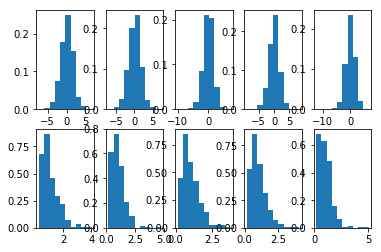


Average val loss: 0.0
Training with lr 1.0000000000000002e-06...
  900 / 15002: loss : 5.6220 -- perceptual loss : 1.3551 -- style loss : 4.2669 -- disentanglement loss : 0.0000 -- kld loss : 2007.3860
Validation...


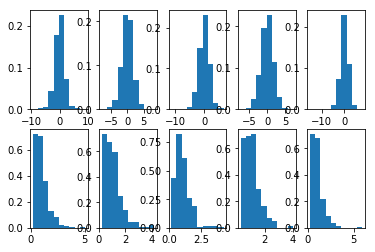


Average val loss: 0.0
Training with lr 1.0000000000000002e-06...
 1000 / 15002: loss : 7.0499 -- perceptual loss : 1.2851 -- style loss : 5.7648 -- disentanglement loss : 0.0522 -- kld loss : 2176.8926
Validation...


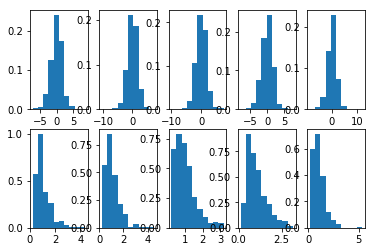


Average val loss: 0.0
Training with lr 1.0000000000000002e-06...
 1100 / 15002: loss : 5.5075 -- perceptual loss : 1.3473 -- style loss : 4.1603 -- disentanglement loss : 0.2272 -- kld loss : 2023.9946
Validation...


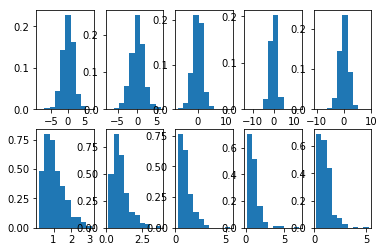


Average val loss: 0.0
Training with lr 1.0000000000000002e-06...
 1200 / 15002: loss : 7.6255 -- perceptual loss : 1.2542 -- style loss : 6.3713 -- disentanglement loss : 0.0000 -- kld loss : 2160.1711
Validation...


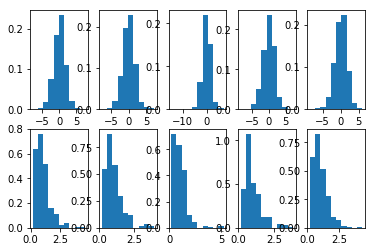


Average val loss: 0.0
Epoch    12: reducing learning rate of group 0 to 1.0000e-07.
Training with lr 1.0000000000000002e-07...
 1300 / 15002: loss : 4.4451 -- perceptual loss : 1.1750 -- style loss : 3.2701 -- disentanglement loss : 0.0953 -- kld loss : 2061.8606
Validation...


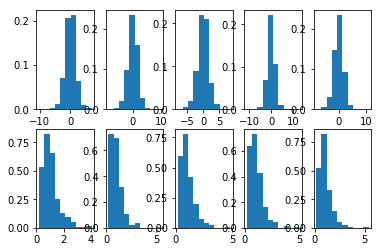


Average val loss: 0.0
Training with lr 1.0000000000000002e-07...
 1400 / 15002: loss : 5.7987 -- perceptual loss : 1.2312 -- style loss : 4.5674 -- disentanglement loss : 0.0434 -- kld loss : 2016.6583
Validation...


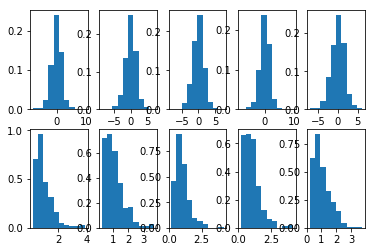


Average val loss: 0.0
Training with lr 1.0000000000000002e-07...
 1500 / 15002: loss : 5.2571 -- perceptual loss : 1.2265 -- style loss : 4.0305 -- disentanglement loss : 0.0000 -- kld loss : 2203.1719
Validation...


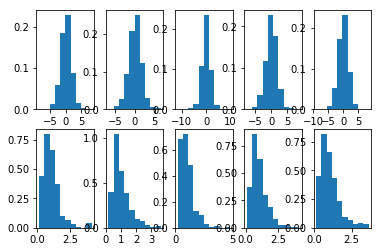


Average val loss: 0.0
Training with lr 1.0000000000000002e-07...


KeyboardInterrupt: 

In [12]:
iteration = 0
val_step = 0
for (content_image_1, content_path_1), (content_image_2, content_path_2), (style_image, style_path) in data_loader_train:
    if iteration >= ITERATIONS: 
        break
    if torch.cuda.is_available():
        content_image_1 = content_image_1.to('cuda')
        content_image_2 = content_image_2.to('cuda')
        style_image = style_image.to('cuda')
    
    unet.train(), style_encoder.train()
    optimizer.zero_grad()
    
    stylized_1, stylized_2, style_encoding, style_mean, style_logvar = forward(content_image_1, content_image_2, style_image)
    total_loss, perceptual_loss, style_loss, disentanglement_loss, kld_loss = losses(content_image_1, style_image, stylized_1, stylized_2, style_encoding, style_mean, style_logvar)
    
    total_loss.backward()
    optimizer.step()
    
    tb_writer.add_scalar('train loss', total_loss.item(), iteration)
    tb_writer.add_scalar('train perceptual loss', perceptual_loss.item(), iteration)
    tb_writer.add_scalar('train style loss', style_loss.item(), iteration)
    tb_writer.add_scalar('train disentanglement loss', disentanglement_loss.item(), iteration)
    tb_writer.add_scalar('train kld loss', kld_loss.item(), iteration)
    print(f'\r{iteration:5d} / {ITERATIONS}: loss : {total_loss.item():.4f} -- perceptual loss : {perceptual_loss.item():.4f} -- style loss : {style_loss.item():.4f} -- disentanglement loss : {disentanglement_loss.item():.4f} -- kld loss : {kld_loss.item():.4f}', end='\r')
    
    if iteration % 100 == 0:
        #tb_writer.add_images('train images', torch.from_numpy(np.concatenate([
        #    data.vgg_normalization_undo(img.detach().cpu().numpy()) for img in [content_image, style_image, stylized]
        #])), iteration)
        # Validate
        print('\nValidation...')
        total_val_loss = 0.0
        with torch.no_grad():
            val_iteration = 0
            unet.eval(), style_encoder.eval()
            fig = plt.figure()
            for (content_image_1, content_path_1), (content_image_2, content_path_2), (style_image, style_path) in data_loader_val:
                
                if val_iteration >= VAL_ITERATIONS:
                    break
                    
                if torch.cuda.is_available():
                    content_image_1 = content_image_1.to('cuda')
                    content_image_2 = content_image_2.to('cuda')
                    style_image = style_image.to('cuda')
                
                stylized_1, stylized_2, style_encoding, style_mean, style_logvar = forward(content_image_1, content_image_2, style_image)
                total_loss, perceptual_loss, style_loss, disentanglement_loss, kld_loss = losses(content_image_1, style_image, stylized_1, stylized_2, style_encoding, style_mean, style_logvar)

                fig.add_subplot(2, VAL_ITERATIONS, val_iteration + 1)
                plt.hist(style_encoding.detach().cpu().numpy().reshape(-1), density=True)
                fig.add_subplot(2, VAL_ITERATIONS, VAL_ITERATIONS + val_iteration + 1)
                plt.hist(style_encoding.detach().cpu().numpy().std(0), density=True)
                
                tb_writer.add_scalar('val loss', total_loss.item(), iteration)
                tb_writer.add_scalar('val perceptual loss', perceptual_loss.item(), iteration)
                tb_writer.add_scalar('val style loss', style_loss.item(), iteration)
                tb_writer.add_scalar('val disentanglement loss', disentanglement_loss.item(), iteration)
                tb_writer.add_scalar('val kld loss', kld_loss.item(), iteration)
                tb_writer.add_images('validation images 1', torch.from_numpy(np.concatenate([
                    img.detach().cpu().numpy() for img in [content_image_1, style_image, stylized_1]
                ])), val_step)
                tb_writer.add_images('validation images 2', torch.from_numpy(np.concatenate([
                    img.detach().cpu().numpy() for img in [content_image_2, style_image, stylized_2]
                ])), val_step)
                val_iteration += 1
                val_step += 1
                print(f'\r{iteration:5d} / {ITERATIONS}: loss : {total_loss.item():.4f} -- perceptual loss : {perceptual_loss.item():.4f} -- style loss : {style_loss.item():.4f} -- disentanglement loss : {disentanglement_loss.item():.4f} -- kld loss : {kld_loss.item():.4f}', end='\r')
            
            plt.show()
            total_val_loss /= VAL_ITERATIONS
            print(f'\nAverage val loss: {total_val_loss}')
            lr_scheduler.step(total_val_loss)
            print(f'Training with lr {optimizer.param_groups[0]["lr"]}...')
            
            
    iteration += 1
    
    